In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 367, 512, 3)


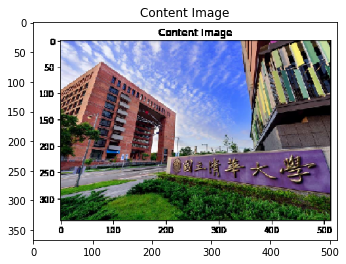

In [5]:
content_path = './dataset/content_nthu.png'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# load pretrained network(VGG19)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [7]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('web_site', 0.88689965),
 ('monitor', 0.041019283),
 ('book_jacket', 0.024434801),
 ('screen', 0.010473803),
 ('menu', 0.0026573804)]

In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# summarize filter shapes
for layer in vgg.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)


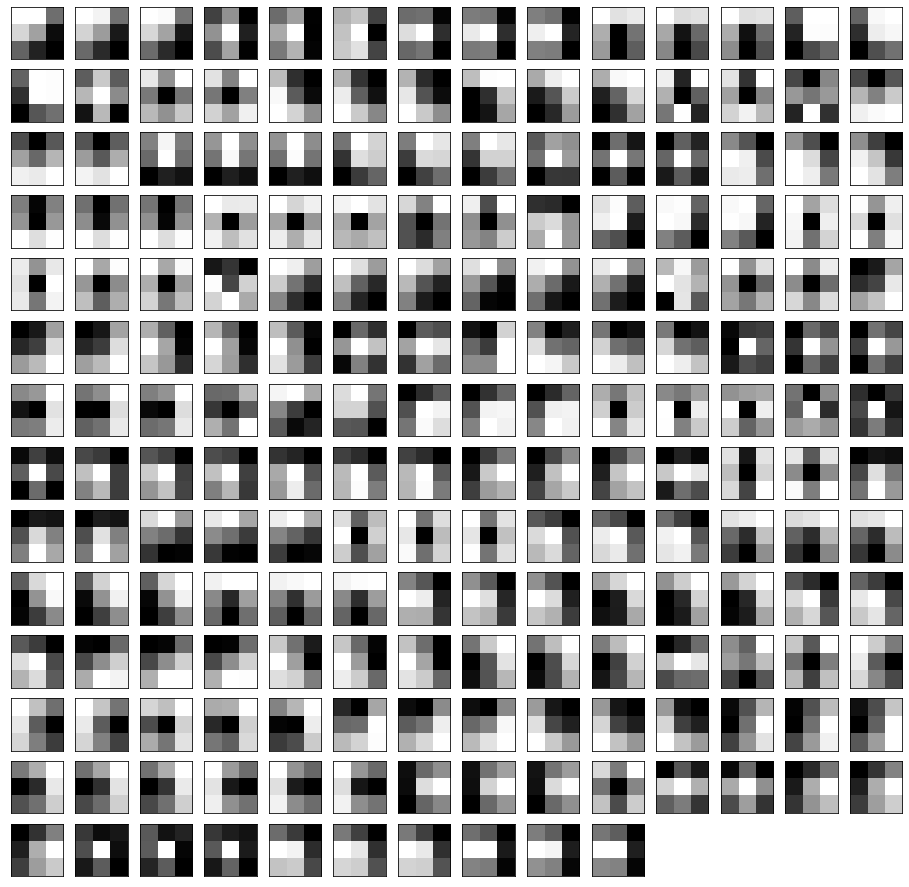

In [10]:
plt.figure(figsize=(16,16))

# retrieve weights from the second hidden layer
filters, biases = vgg.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 64, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


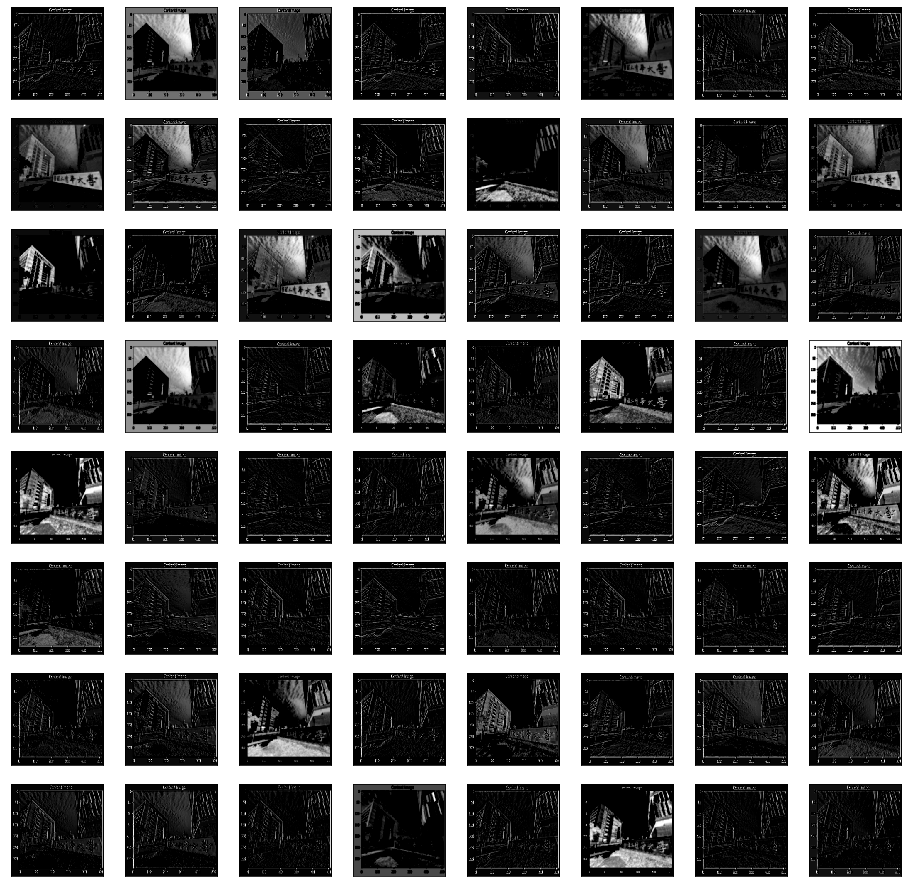

In [11]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[1].output)
model.summary()

# preprocess input
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (224, 224))

# get feature map for first hidden layer
feature_maps = model.predict(content_image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

Tensor("block1_conv2/Identity:0", shape=(None, 224, 224, 64), dtype=float32)


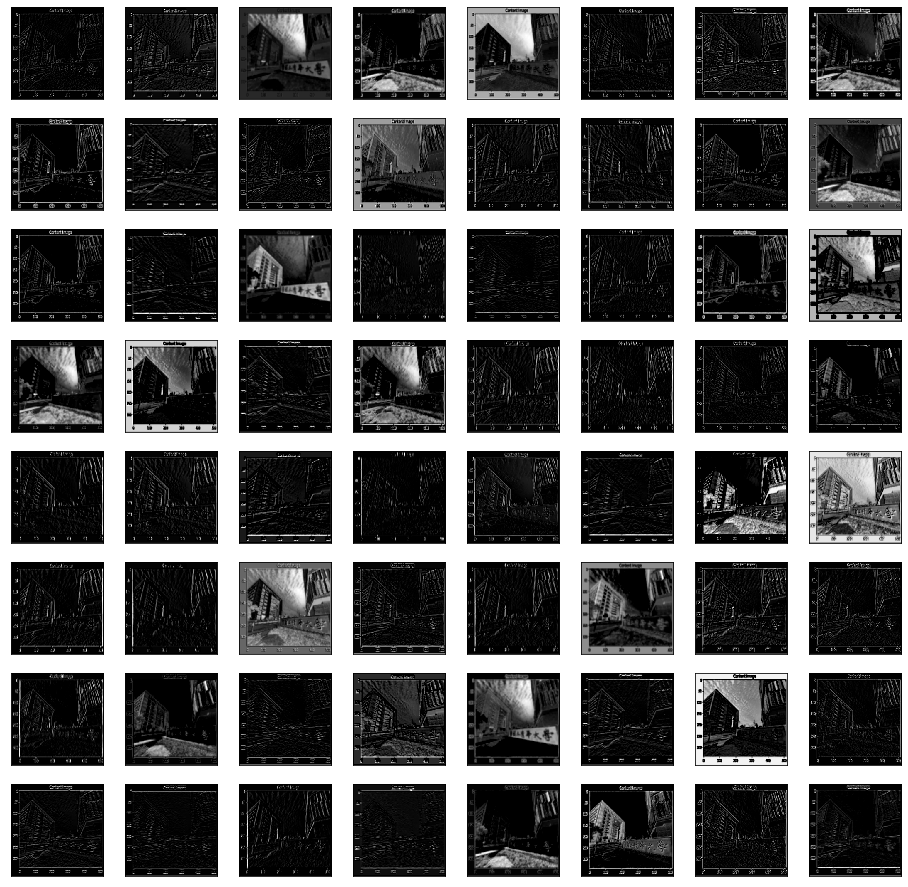

Tensor("block2_conv2/Identity:0", shape=(None, 112, 112, 128), dtype=float32)


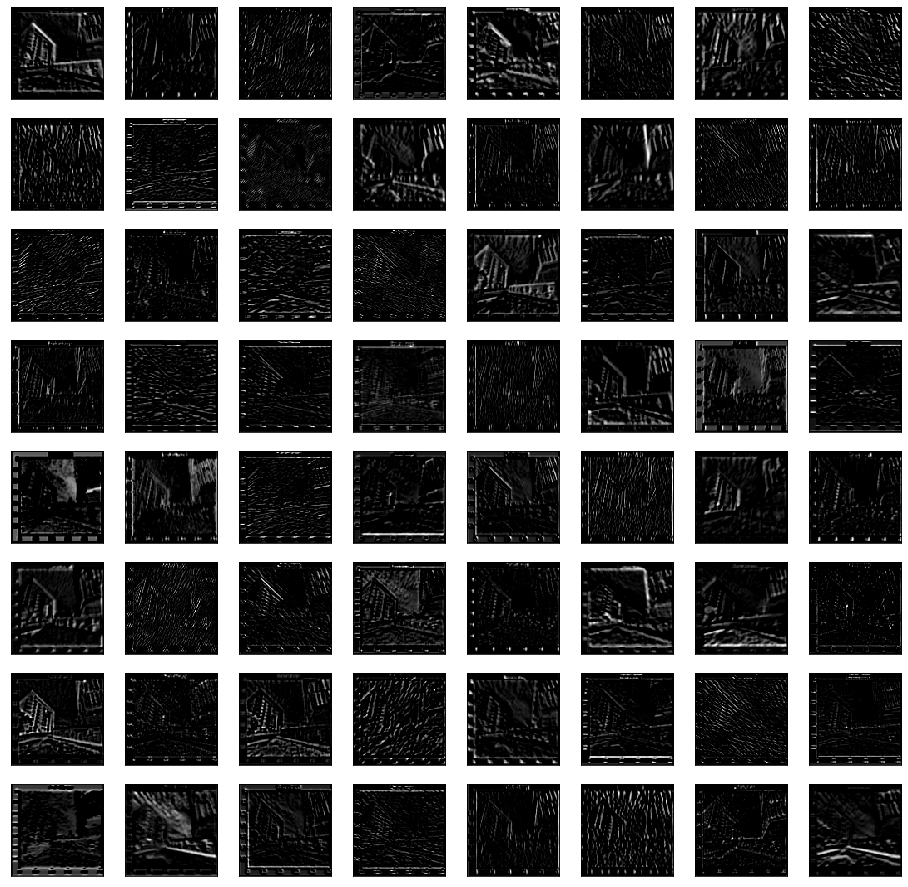

Tensor("block3_conv4/Identity:0", shape=(None, 56, 56, 256), dtype=float32)


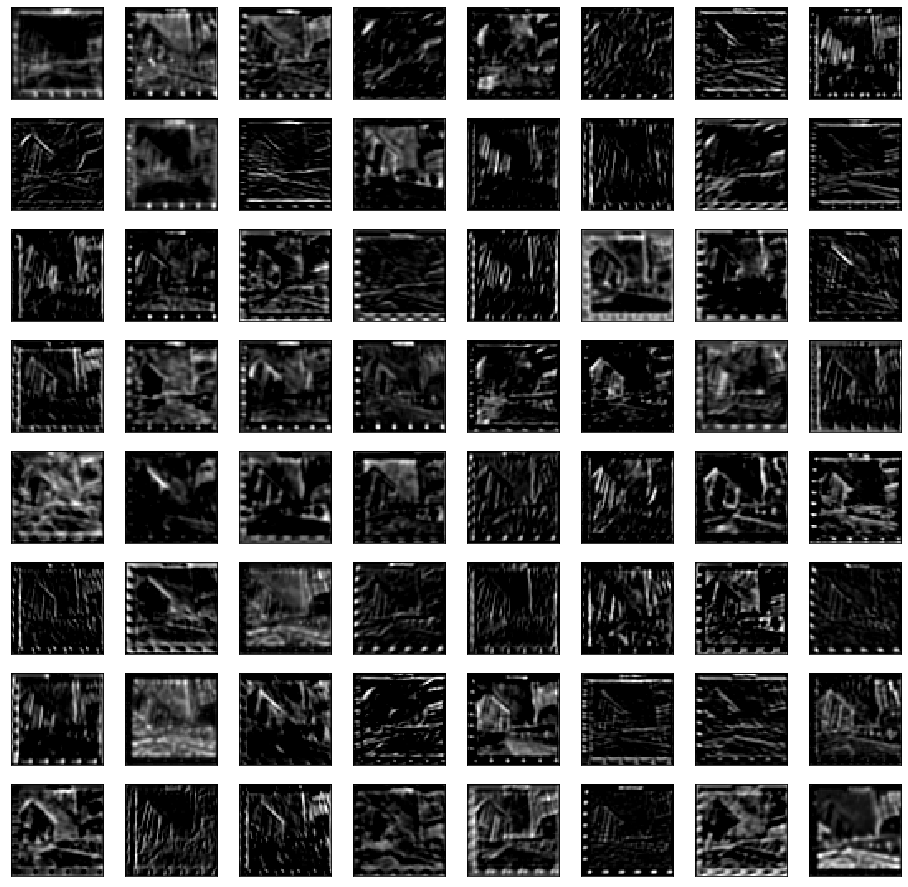

Tensor("block4_conv4/Identity:0", shape=(None, 28, 28, 512), dtype=float32)


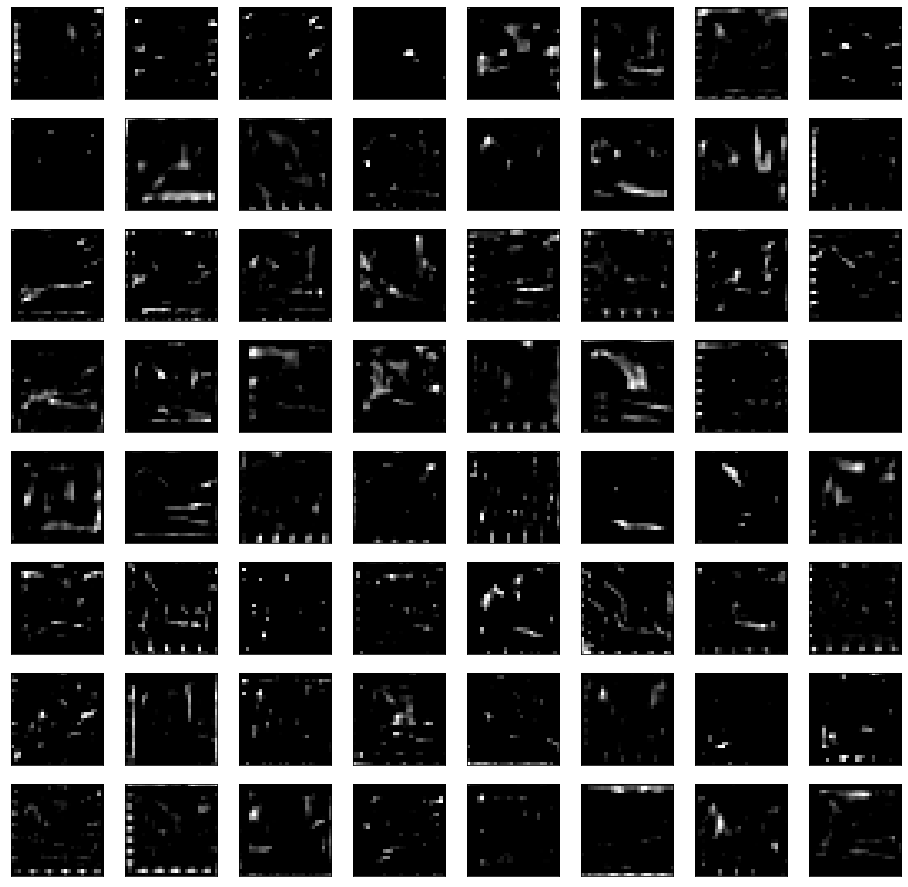

Tensor("block5_conv4/Identity:0", shape=(None, 14, 14, 512), dtype=float32)


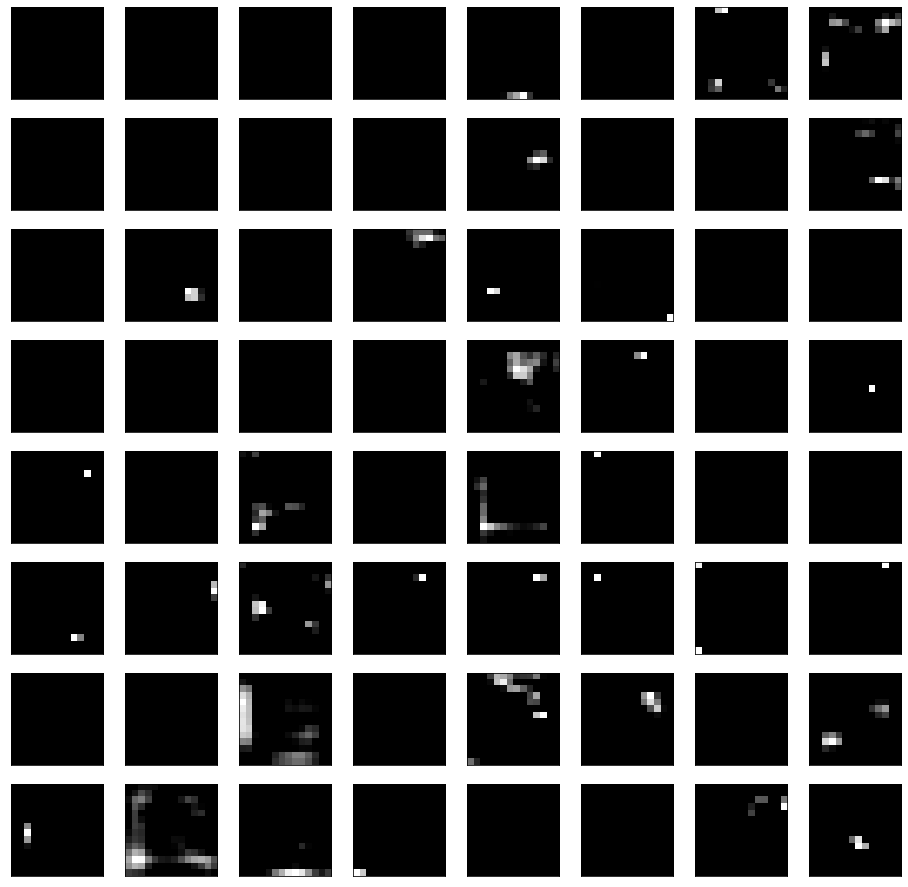

In [12]:
# get feature maps for last convolutional layer in each block
ixs = [2, 5, 10, 15, 20]
outputs = [vgg.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
feature_maps = model.predict(content_image)

# plot the output from each block
square = 8
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
            
    # show the figure
    pyplot.show()

In [13]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
class GradientModel(tf.keras.models.Model):
    def __init__(self, layers):
        super(GradientModel, self).__init__()
        self.vgg =  vgg_layers(layers)
        self.num_style_layers = len(layers)
        self.vgg.trainable = False
        
    # return the feature map of required layer
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs

In [15]:
@tf.function()
def visualize_gradient(image):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        # grad = d_feature/d_image
        grad = tape.gradient(tf.reduce_max(feature, axis=3), image)
    return grad

In [16]:
content_image = load_img(content_path)

# activation layer
layers = ['block4_conv2']
image = tf.Variable(content_image)

extractor = GradientModel(layers)
grad = visualize_gradient(image)

# look at the range of gradients
print("shape: ", grad.numpy().shape)
print("min: ", grad.numpy().min())
print("max: ", grad.numpy().max())
print("mean: ", grad.numpy().mean())

shape:  (1, 367, 512, 3)
min:  -14147.651
max:  16301.115
mean:  -10.122324


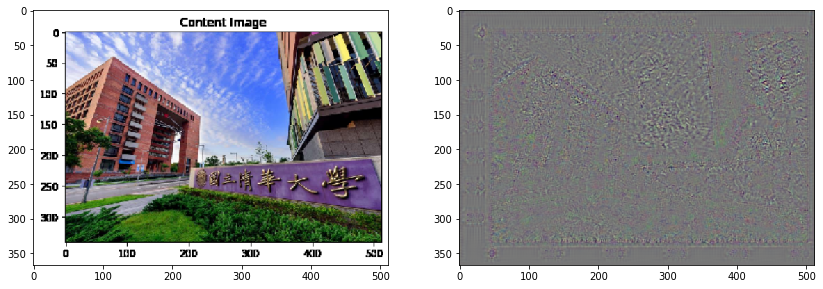

In [17]:
# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])

In [18]:
@tf.function()
def visualize_gradient_single_layer(image, layer_i):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        grad = tape.gradient(tf.reduce_mean(feature[:, :, :, layer_i]), image)
    return grad

<Figure size 1008x720 with 0 Axes>

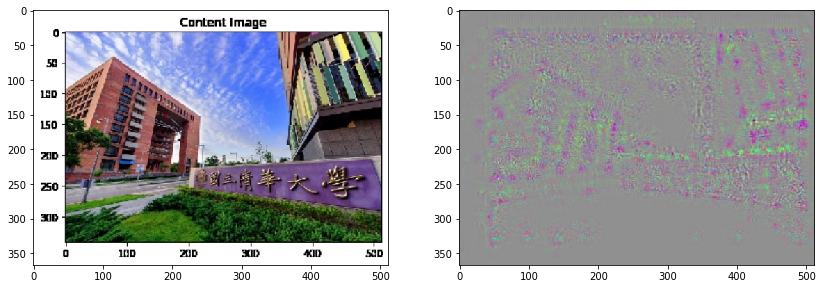

In [19]:
plt.figure(figsize=(14,10))

grad = visualize_gradient_single_layer(image, 77)

# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])

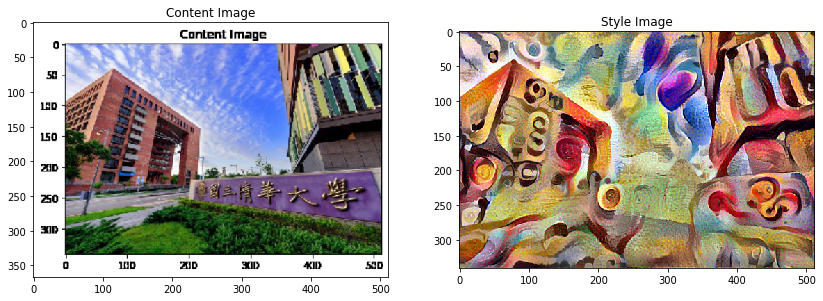

In [20]:
content_path = './dataset/content_nthu.png'
style_path = './dataset/style_transfer_nthu_candy.png'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [21]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [22]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [23]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [24]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 341, 512, 64)
  min:  0.0
  max:  849.39734
  mean:  35.57512

block2_conv1
  shape:  (1, 170, 256, 128)
  min:  0.0
  max:  4268.1704
  mean:  199.48946

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  8687.125
  mean:  223.65887

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  20354.764
  mean:  846.2564

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3561.2668
  mean:  62.1699



In [25]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [26]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [27]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.07531572
    max:  61889.582
    mean:  1064.7408

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  233376.05
    mean:  34319.016

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  945661.1
    mean:  39466.19

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7525592.0
    mean:  409061.53

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  296081.47
    mean:  2868.3823

Contents:
   block5_conv2
    shape:  (1, 22, 32, 512)
    min:  0.0
    max:  1283.838
    mean:  19.903402


In [28]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [29]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [30]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # tape.gradient: d_loss/d_image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

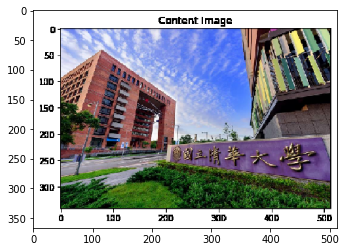

In [31]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 0
content_weight = 0

train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

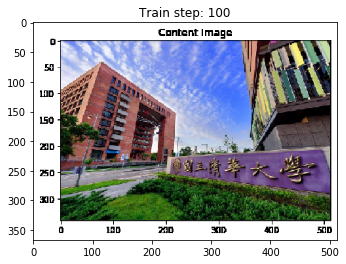

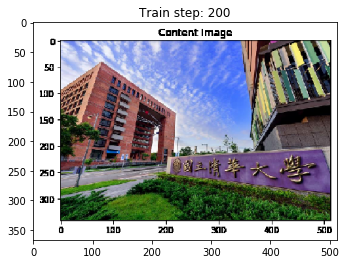

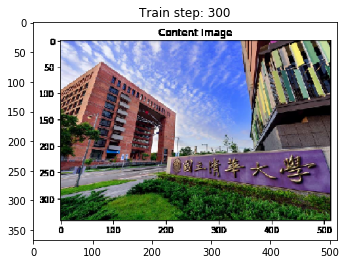

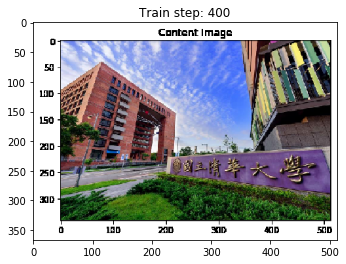

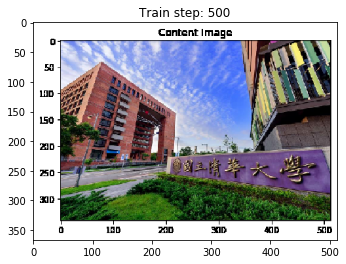

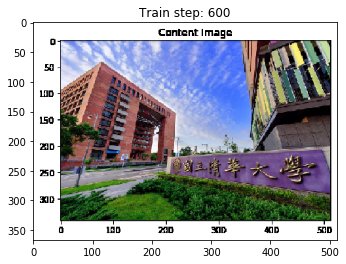

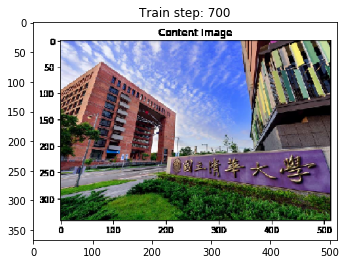

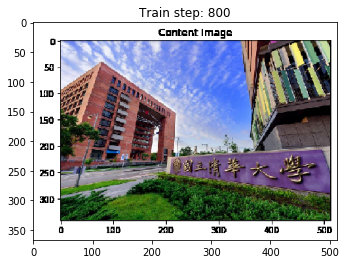

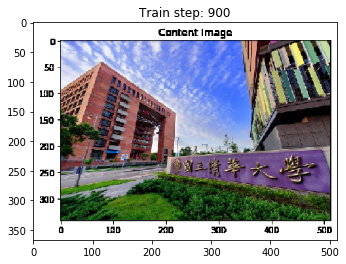

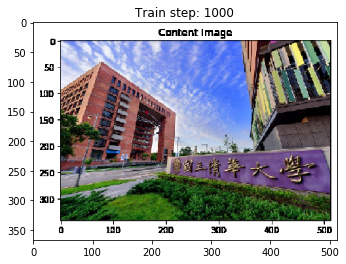

Total time: 87.6


In [32]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    

end = time.time()
print("Total time: {:.1f}".format(end-start))